The code is trying to wrap things up from the [Exercise](https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html)  in the last chapter of book 'Python for data science'.
Several Deprecations are fixed and data will be shuffled before getting trained

The optimal solution would be wrapping everything up in a large class, or connecting small classes by pipeline.
But this requires a good understanding of sklearn.pipeline because the input data is not in a format of (x, y). Generalizing the  large class to contain the flexibility of applying to any model is even harder task.
There should be a lof of things need to be customized.

Anyway, that is left for a future assignment.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import skimage
from skimage import feature
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.datasets import fetch_lfw_people
from itertools import chain

In [2]:
class WrappedUp():
    
    def __init__(self, positive_patches, negative_imgs, patches_per_img=1000, scale=[0.5, 1.0, 2.0], shflseed=10):
        self.positive_patches = positive_patches
        self.negative_patches = np.vstack([self.extract_patches(im, patches_per_img, positive_patches[0].shape, scale = scl) 
                                           for im in negative_imgs for scl in scale])
        
        print('positive_patches_shape:', positive_patches.shape)
        print('negative_patches_shape:', self.negative_patches.shape)
        
        print('\nData Transformation Starting\n...')
        self.X_train, self.y_train = self.cmb_shfl(rseed=shflseed)
        print('\nData Transformation Finished')

        
    @staticmethod    
    def extract_patches(img, N, patch_size, scale=1.0):
    
        #rescale the output size
        extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    
        #define the extractor given designated size
        extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    
        #extract 1000 small patches from 1 large picture
        patches = extractor.transform(img[np.newaxis])
        if scale != 1.:
            patches = np.array([skimage.transform.resize(patch, patch_size, mode='constant', anti_aliasing=False)
                            for patch in patches])
        return patches
    
    
    def cmb_shfl(self, rseed):
        X_train = np.array([feature.hog(im, block_norm='L1')
                    for im in chain(self.positive_patches,
                                    self.negative_patches)])
        n_obs = X_train.shape[0]
        
        y_train = np.zeros(n_obs)
        y_train[:self.positive_patches.shape[0]] = 1
        
        rnd = np.random.RandomState(rseed)
        idx = rnd.permutation(n_obs)

        return X_train[idx], y_train[idx]
    
    def sliding_window(self, img, istep=2, jstep=2, scale=1.0):
        Ni, Nj = (int(scale * s) for s in self.positive_patches[0].shape)
        for i in range(0, img.shape[0] - Ni, istep):
            for j in range(0, img.shape[1] - Ni, jstep):
                patch = img[i:i + Ni, j:j + Nj]
                if scale != 1:
                    patch = transform.resize(patch, patch_size, mode = 'constant', anti_aliasing=False)
                yield (i, j), patch

In [3]:
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape


imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

#extract data by given labels
#only ten pictures! no more data
images = [skimage.color.rgb2gray(getattr(skimage.data, name)())
          for name in imgs_to_use]

In [4]:
test = WrappedUp(positive_patches, negative_imgs=images)

positive_patches_shape: (13233, 62, 47)
negative_patches_shape: (30000, 62, 47)

Data Transformation Starting
...

Data Transformation Finished


In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = test.X_train, test.y_train
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)
grid.fit(X_train, y_train)
print('Best score is ', grid.best_score_)

model = grid.best_estimator_
model.fit(X_train, y_train)

Best score is  0.9920893761709805


LinearSVC(C=8.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

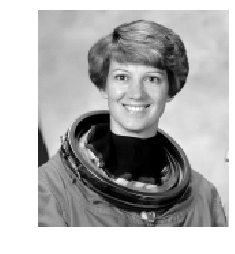

In [6]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, mode = 'constant', anti_aliasing=False, multichannel=False)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [7]:
indices, patches = zip(* test.sliding_window(test_image))

patches_hog = np.array([feature.hog(patch, block_norm='L1') for patch in patches])
patches_hog.shape

(1911, 1215)

In [8]:
labels = model.predict(patches_hog)
labels.sum()

34.0

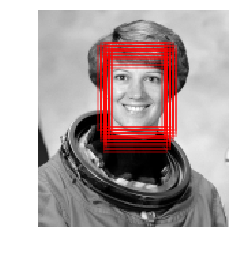

In [9]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))